In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate, configure_plot_style, AIBM_COLORS

configure_plot_style()

## Read the data

In [3]:
xlabel = 'Labor force participation rate'

In [4]:
!ls *.csv

owid_literacy.csv		wef_primary_enrolment.csv
wef_earned_income.csv		wef_primary_enrolment_table.csv
wef_earned_income_table.csv	wef_professional_and_technical_workers.csv
wef_economic_participation.csv	wef_professionals_table.csv
wef_educational_attainment.csv	wef_secondary_enrolment.csv
wef_labour_participation.csv	wef_secondary_enrolment_table.csv
wef_legislators.csv		wef_tertiary_enrolment.csv
wef_legislators_table.csv	wef_tertiary_enrolment_table.csv
wef_literacy_rate.csv		wef_wage_equality.csv
wef_literacy_rate_table.csv	wef_wage_equality_table.csv


In [5]:

import os
from extract_pdf_data import read_pdfs

filename = "wef_labour_participation.csv"
if not os.path.exists(filename):
    df = read_pdfs('labour-force participation rate')
    df.to_csv(filename, index=False)

In [6]:
from utils import read_wef_file

df = read_wef_file(filename)
df.head()

,country,page_number,score,rank,diff,left,right
code,,,,,,,
ALB,Albania,83,0.778,73,-15.06,52.87,67.93
DZA,Algeria,85,0.255,142,-49.55,16.94,66.49
AGO,Angola,87,0.956,4,-3.44,74.72,78.16
ARG,Argentina,89,0.726,92,-19.66,52.08,71.74
ARM,Armenia,91,0.874,30,-9.04,62.80,71.84


In [7]:
df['rank'].value_counts(dropna=False).head()

rank
73     1
142    1
4      1
92     1
30     1
Name: count, dtype: int64

In [8]:
df['score'].describe()

count    146.000000
mean       0.733788
std        0.172988
min        0.201000
25%        0.659750
50%        0.775000
75%        0.865000
max        0.991000
Name: score, dtype: float64

In [9]:
dinged = df['score'] < 1
dinged.sum()

np.int64(146)

Here is the distribution of their scores.

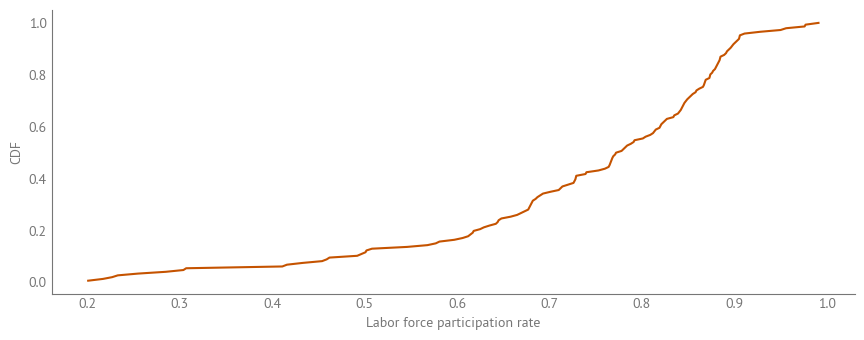

In [10]:
from empiricaldist import Cdf

cdf_score = Cdf.from_seq(df.loc[dinged, 'score'])
cdf_score.plot()
decorate(xlabel=xlabel, ylabel='CDF')

Here is the distribution of differences (female minus male in percentage points) for all countries with valid data.

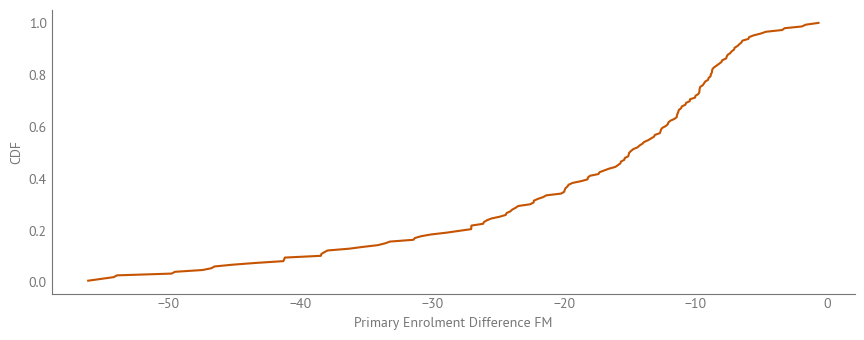

In [11]:
cdf_difference_fm = Cdf.from_seq(df['diff'])
cdf_difference_fm.plot()
decorate(xlabel='Primary Enrolment Difference FM', ylabel='CDF')

In [12]:
subset = df[dinged]
subset.sort_values("diff", ascending=False)

,country,page_number,score,rank,diff,left,right
code,,,,,,,
BDI,Burundi,129,0.991,1,-0.69,78.25,78.94
MDA,Moldova,259,0.977,2,-1.65,69.90,71.55
MOZ,Mozambique,267,0.976,3,-1.95,78.14,80.09
GHA,Ghana,189,0.950,5,-3.27,61.98,65.24
AGO,Angola,87,0.956,4,-3.44,74.72,78.16
...,...,...,...,...,...,...,...
MAR,Morocco,265,0.285,141,-49.80,19.80,69.60
IRN,Iran,209,0.201,146,-53.96,13.58,67.54
EGY,Egypt,167,0.217,145,-54.20,15.00,69.20


## Revised scores

The scores are based on ratios, not differences, so let's compute those.

In [13]:
df['ratio'] = df['left'] / df['right']
df['ratio'].describe()

count    146.000000
mean       0.733737
std        0.173026
min        0.201066
25%        0.659355
50%        0.775202
75%        0.865065
max        0.991259
Name: ratio, dtype: float64

Looks like the ratio IS the score.

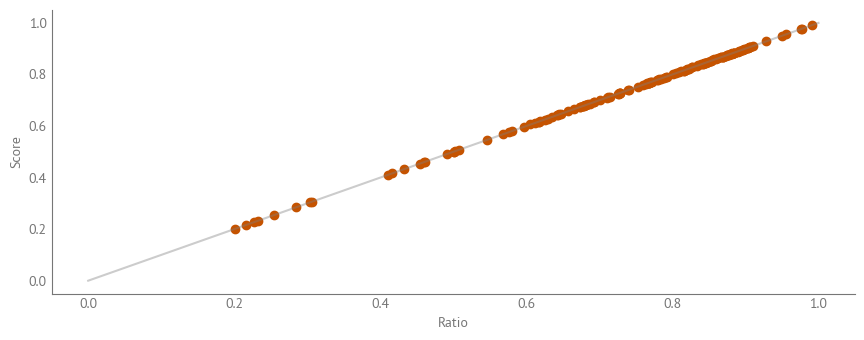

In [14]:
subset = df[dinged]
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(subset['ratio'], subset['score'])
decorate(xlabel='Ratio', ylabel='Score')

So here are the revised, symmetric scores.

In [15]:
df['revised_score'] = df['ratio']
df['revised_score'].describe()

count    146.000000
mean       0.733737
std        0.173026
min        0.201066
25%        0.659355
50%        0.775202
75%        0.865065
max        0.991259
Name: revised_score, dtype: float64

Here's the distribution of revised scores.

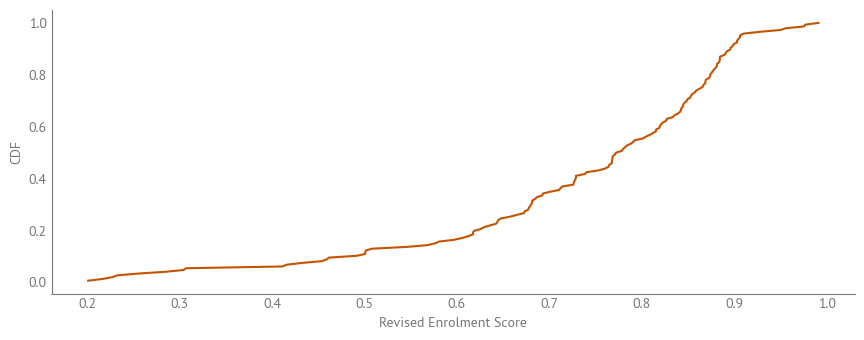

In [16]:
cdf_score = Cdf.from_seq(df['revised_score'])
cdf_score.plot()
decorate(xlabel='Revised Enrolment Score', ylabel='CDF')

Here's the distribution of revised scores, compare to the original.

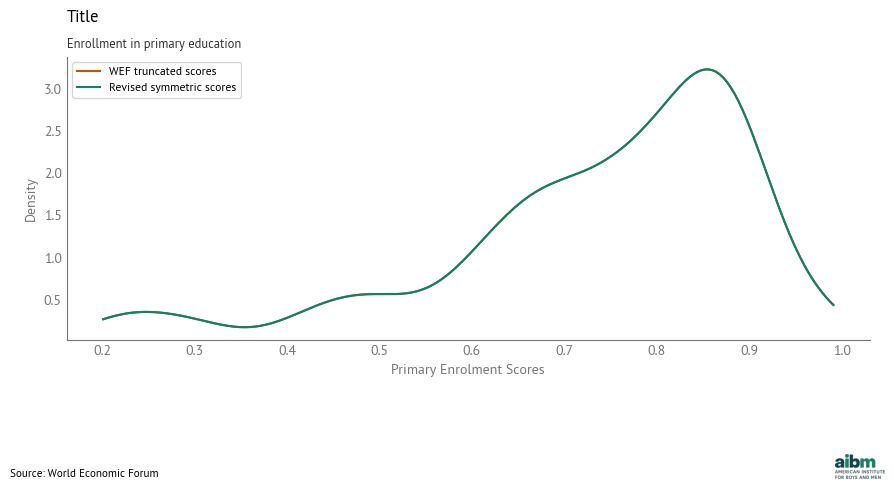

In [17]:
from utils import plot_score_distributions, add_title

plot_score_distributions(df, xlabel='Primary Enrolment Scores')
add_title("Title",
          "Enrollment in primary education")

In [18]:
revised = df[~dinged].dropna(subset=['ratio']).sort_values('revised_score')
revised.shape

(0, 9)

In [19]:
from utils import plot_revised_scores

# plot_revised_scores(revised)

## Export the results

In [20]:
from utils import make_rank_table

table = make_rank_table(df)
table.to_csv("wef_labour_participation_table.csv")
table.shape

(146, 6)

In [21]:
table['score'].describe()

count    146.000000
mean       0.733788
std        0.172988
min        0.201000
25%        0.659750
50%        0.775000
75%        0.865000
max        0.991000
Name: score, dtype: float64

In [22]:
from utils import make_weight_table

make_weight_table(table, 'primary')

original             revised          
              std   inv std       std   inv std
primary  0.172988  0.057807  0.173026  0.057795

## OECD countries

In [23]:
from utils import oecd_codes

df_oecd = df.loc[oecd_codes].sort_values(by='revised_score')

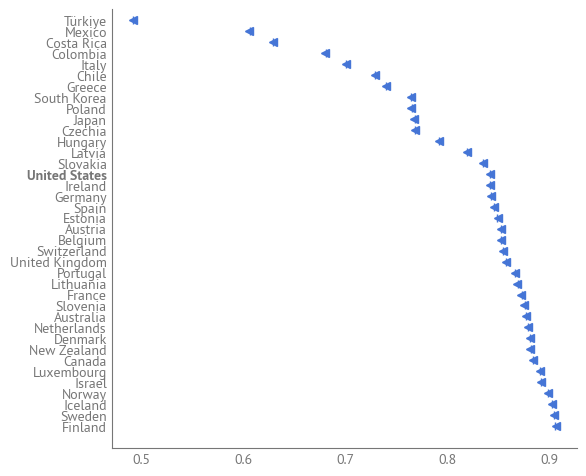

In [24]:
plot_revised_scores(df_oecd)

In [25]:
df.query("country == 'Ireland'")

,country,page_number,score,rank,diff,left,right,ratio,revised_score,revised_rank
code,,,,,,,,,,
IRL,Ireland,211,0.842,50,-11.12,59.4,70.51,0.842434,0.842434,50.0
